# References

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.sys.path.append('../fastai/') #fastai version 1

from pathlib import Path
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary

import fastai
from fastai import *
from fastai.vision import *
from fastai.vision.image import *

# Global Variables

In [2]:
DP = Path('/home/Deep_Learner/work/datasets/human-protein-atlas-image-classification/')
STAGE_ONE_DATA = DP/'stage1_data'
TRAIN_PNGS = 'train_pngs_512'
TEST_PNGS = 'test_pngs_512'
TRAIN_CSV = 'train.csv'
SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'


SUBMISSIONS = DP/STAGE_ONE_DATA/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)


filter_colors = ['blue', 'green', 'red', 'yellow']

IdToCatDict = {0:'Nucleoplasm',
               1:'Nuclear_membrane',
               2:'Nucleoli',
               3:'Nucleoli_fibrillar_center',
               4:'Nuclear_speckles',
               5:'Nuclear_bodies',
               6:'Endoplasmic_reticulum',
               7:'Golgi_apparatus',
               8:'Peroxisomes',
               9:'Endosomes',
               10:'Lysosomes',
               11:'Intermediate_filaments',
               12:'Actin_filaments',
               13:'Focal_adhesion_sites',
               14:'Microtubules',
               15:'Microtubule_ends',
               16:'Cytokinetic_bridge',
               17:'Mitotic_spindle',
               18:'Microtubule_organizing_center',
               19:'Centrosome',
               20:'Lipid_droplets',
               21:'Plasma_membrane',
               22:'Cell_junctions',
               23:'Mitochondria',
               24:'Aggresome',
               25:'Cytosol',
               26:'Cytoplasmic_bodies',
               27:'Rods_&_rings'}

sz = 512
original_img_sz = 512
bs = 16
val_split = 0.2
np.random.seed(42)

# Data

In [3]:
def open_4_channel(fname):
    fname = str(fname)
    # strip extension before adding color
    if fname.endswith('.png'):
        fname = fname[:-4]
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(fname+'_'+color+'.png', flags).astype(np.float32)/255
           for color in colors]
    
    x = np.stack(img, axis=-1)
    return Image(pil2tensor(x, np.float32).float())

## class ImageMulti4Channel(ImageMultiDataset):

In [4]:
class ImageMulti4Channel(ImageMultiDataset):
    def __init__(self, fns, labels, classes=None, **kwargs):
        super().__init__(fns, labels, classes, **kwargs)
        self.image_opener = open_4_channel
        
df = pd.read_csv(STAGE_ONE_DATA/TRAIN_CSV)
fns = pd.Series([id + '.png' for id in df.Id])
labels = [targ.split(' ') for targ in df.Target]
trn_ds, val_ds = ImageMulti4Channel.from_folder(path=STAGE_ONE_DATA,
                                                folder=TRAIN_PNGS, 
                                                fns=fns, 
                                                labels=labels,
                                                valid_pct = val_split,
                                                classes=[str(i) for i in range(28)])

df_test = pd.read_csv(STAGE_ONE_DATA/SAMPLE_SUBMISSION_CSV)
fns_test = pd.Series([id + '.png' for id in df_test.Id])
labels_test = [str(targ).split(' ') for targ in df_test.Predicted]
test_ds,_ = ImageMulti4Channel.from_folder(
    path = STAGE_ONE_DATA, 
    folder=TEST_PNGS, 
    fns=fns_test, 
    labels=labels_test,
    valid_pct=0,
    classes=['0'])

trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

data = ImageDataBunch.create(trn_ds, 
                             val_ds, 
                             test_ds=test_ds, 
                             path=STAGE_ONE_DATA, 
                             bs=bs, 
                             ds_tfms=(trn_tfms, []), 
                             num_workers=8, size=sz).normalize(protein_stats)

../fastai/fastai/vision/data.py:122: UserWarning: `ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.
  warnings.warn("`ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.")


## Fastai data_block api

In [5]:
vision.data.open_image = open_4_channel

In [105]:
data = ImageFileList.from_csv(path=STAGE_ONE_DATA, 
                               csv_name=TRAIN_CSV, 
                               col='Id')

In [98]:
data = data.label_from_csv(csv_fname=TRAIN_CSV, 
                           fn_col=0, 
                           label_col=1, 
                           sep=' ', 
                           folder=TRAIN_PNGS, 
                           suffix='.png') 

In [99]:
data = data.random_split_by_pct(val_split)
        

In [100]:
#data = data.add_test_folder(test_folder=TEST_PNGS, label=[-1])

In [101]:
data = data.datasets()        

TypeError: __init__() missing 2 required positional arguments: 'x' and 'y'

In [103]:
data = data.transform(tfms, size=sz)     

AttributeError: 'ImageSplitData' object has no attribute 'transform'

In [104]:
data = data.databunch()

AttributeError: 'ImageSplitData' object has no attribute 'databunch'

# Loss Function/Metrics

In [5]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()


f1_score = partial(fbeta, thresh=0.5, beta=1)

# Model

In [6]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}


class Resnet4Channel(nn.Module):
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()

        self.encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        
        w = self.encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        
        self.bn1 = self.encoder.bn1
        self.relu = nn.ReLU(inplace=True) 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.encoder.layer1
        self.layer2 = self.encoder.layer2
        self.layer3 = self.encoder.layer3
        self.layer4 = self.encoder.layer4
        
        self.avgpool = self.encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth==34 else 4), num_classes)        
        
        #self.custom_head = fastai.vision.learner.create_head(nf = 512 * (1 if encoder_depth==34 else 4)*2, nc = num_classes)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        #x = self.custom_head(x)
        
        return x

# Train

In [17]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Resnet4Channel(50).to(device)
summary(model, (4, sz, sz))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]          12,544
       BatchNorm2d-2         [-1, 64, 256, 256]             128
       BatchNorm2d-3         [-1, 64, 256, 256]             128
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6         [-1, 64, 128, 128]           4,096
            Conv2d-7         [-1, 64, 128, 128]           4,096
       BatchNorm2d-8         [-1, 64, 128, 128]             128
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
             ReLU-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
           Conv2d-13         [-1, 64, 128, 128]          36,864
      BatchNorm2d-14         [-1, 64, 1

In [18]:
model

Resnet4Channel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0)

In [19]:
learn = ClassificationLearner(
    data=data,
    model=model,
    loss_func=F.binary_cross_entropy_with_logits,
    #loss_func=FocalLoss(),
    path=STAGE_ONE_DATA,    
    metrics=[f1_score]
)

#learn = create_cnn(data=data, arch=model, metrics=[f1_score])

In [ ]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


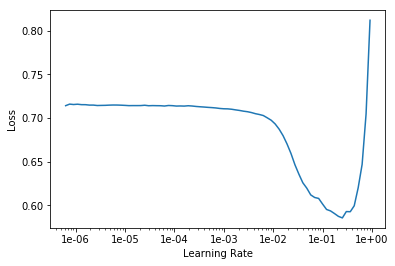

In [22]:
learn.recorder.plot()

In [23]:
lr = 0.01

In [24]:
#learn.freeze_to(-12)

In [26]:
#learn.fit(1, lr)

Total time: 13:09
epoch  train_loss  valid_loss  fbeta   
1      0.206896    1.793007    0.158405  (13:09)



In [27]:
#learn.unfreeze()

In [31]:
learn.fit_one_cycle(20, slice(lr))

Total time: 4:19:15
epoch  train_loss  valid_loss  fbeta      
1      0.160634    1.968509    0.202988     (13:03)
2      0.172951    36.358135   0.119728     (13:03)
3      0.174315    379.290405  0.145940     (13:01)
4      0.177522    6860.312012  0.087006    (13:01)
5      0.195291    19.312492   0.290294     (12:59)
6      0.199401    3421.173096  0.151579    (13:03)
7      0.189825    3890.949951  0.092510    (13:00)
8      0.193235    5218.625488  0.085218    (13:00)
9      0.185116    615.447876  0.111206     (12:59)
10     0.185031    7293.870117  0.123527    (13:00)
11     0.188973    368415.000000  0.082437  (13:01)
12     0.170449    155.008591  0.040117     (12:58)
13     0.166298    204.119202  0.163346     (13:00)
14     0.157560    228.819366  0.061087     (12:26)
15     0.154693    14.067640   0.107645     (12:33)
16     0.149470    48.349648   0.245781     (12:59)
17     0.138321    0.274224    0.333268     (12:59)
18     0.136218    1.098433    0.345614     (13:01)
1

In [32]:
learn.save('resnet50_sz512_bs16_unchangedHead')

# Predictions

In [33]:
preds,_ = learn.get_preds(DatasetType.Test)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1129: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [35]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':df_test.Id,'Predicted':pred_labels})
df.to_csv(SUBMISSIONS/'resnet50_sz512_bs16_unchangedHead.csv', header=True, index=False)